## **Reach-to-Palpate Task**

In this task, we are going to train a network on a small set of color images & joint trajectories. The goal of this task is to train a network that can take in color image of the breast phantom in home pose and returns a set a ProMP weights. These weights are used to forward-calculate the robot joint trajectory. 

Some important points are: 

1) These images of breast phantom are taken from robot home position. 

2) Then the robot was moved to reach the palpation start point. 

3) The palpation start point is always breast phantom nipple. 

4) The workspace area in XY-direction (in camera view) when the robot is at home position was dividied into 4 reigons i.e. A, B, C, D. 

5) The breast phantom was placed in all four regions. 

6) While the robot was moving, all its joint positions, speeds and accceralations were recorded as well.


In [ ]:
# to access the google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# to import local python modules.
import sys
sys.path.insert(0,"/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/rtp_cnn/")
from promp import ProMP

In [ ]:
# imports
import os
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from tensorflow.python.keras.metrics import MeanMetricWrapper
import abc
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import random


In [ ]:
def load_encoded_images(img_dir, id_list, encoder, resize_shape = None, normalize = False) -> np.ndarray:
  """Load multiple images by ID from a directory an pass them through an encoder model.

  Args:
      img_dir (str): Path of the directory.
      id_list (np.ndarray): List of image id
      encoder (tf.keras.Model): The encoder model.
      resize_shape (tuple[int], optional): If specified, reshape all images to this shape. Defaults to None.
      normalize (bool, optional): If True, normalize the image in [-1, 1]. Defaults to False.

  Returns:
      np.ndarray: The image data with shape (samples, width, height, channels).
  """
  return np.array([load_encoded_image(os.path.join(img_dir, id + ".png"), encoder, resize_shape, normalize) for id in id_list])

In [ ]:
def load_encoded_image(img_path, encoder, resize_shape = None, normalize = False) -> np.ndarray:
    """Load an image an pass it through an encoder model.

    Args:
        img_path (str): Path of the image.
        encoder (tf.keras.Model): The encoder model.
        resize_shape (tuple[int], optional): If specified, reshape all images to this shape. Defaults to None.
        normalize (bool, optional): If True, normalize the image in [-1, 1]. Defaults to False.

    Returns:
        np.ndarray: The image data with shape (width, height, channels).
    """
    return np.squeeze(encoder(np.expand_dims(load_image(img_path, resize_shape, normalize), axis=0)))

In [ ]:
def load_image(img_path, resize_shape = None, normalize = False) -> np.ndarray:
    """Load an image from file.

    Args:
        img_path (str): Path of the image.
        resize_shape (tuple[int], optional): If specified, reshape all images to this shape. Defaults to None.
        normalize (bool, optional): If True, normalize the image in [-1, 1]. Defaults to False.

    Returns:
        np.ndarray: The image data.
    """

    img = imread(img_path, pilmode='RGB')
    if resize_shape:
        img = resize(img, resize_shape)
    if normalize:
        img = normalize_negative_one(img)
    return img

In [ ]:
def normalize_negative_one(img):
    normalized_input = (img - np.amin(img)) / (np.amax(img) - np.amin(img))
    return 2*normalized_input - 1

In [ ]:
def load_array_from_json(dir_path, json_key, id_list, slicer = None):
    """Load (a slice of) a Numpy array from multiple JSON files in a folder.

    Can be used, for example, to load joint states from multiple trajectory files.

    Args:
        dir_path (str): The path of the directory containing the files.
        json_keys (list[str]): The keys to be read from the JSON files.
        id_list (list[str]): The ids of the files to be read.
        slicer (tuple[slice], optional): If specified, slice every array accoroding to this slicer. Defaults to None.

    Returns:
        list[np.ndarray]: An array for each key.
    """

    data = []
    for id in id_list:
        file_path = os.path.join(dir_path, f"{id}.json")
        with open(file_path, "r") as file:
            json_data = json.load(file)[json_key]
            arr = np.array(json_data)
            if slicer:
                arr = arr[slicer]
            data.append(arr)
    return data

In [ ]:
def get_joint_loss(promp):
    """Obtain the loss function evaluating the RMSE on the joint trajectories from the full ProMP weights (in TensorFlow).

    Args:
        promp (ProMP): An initialized ProMP instance.

    Returns:
        The loss function
    """

    def joint_loss(promp_true, promp_pred):
        """RMSE loss on the joint trajectory from the full ProMP weights.

        Args:
            promp_true: Ground truth full ProMP weights with shape (n_batch, n_basis * n_dof).
            promp_pred: Predicted full ProMP weights with shape (n_batch, n_basis * n_dof).

        Returns:
            The resulting loss.
        """
        traj_true = promp.trajectory_from_weights_tf(promp_true)
        traj_pred = promp.trajectory_from_weights_tf(promp_pred)
        # RMSE on joint trajectories.
        loss = tf.sqrt(tf.reduce_mean(tf.square(traj_true - traj_pred), axis=1))
        # Average over batches and joints.
        loss = tf.reduce_mean(loss)
        return loss

    return joint_loss

In [ ]:
# Create ProMP objects 
n_basis = 10 
n_dof = 7
n_t = 100
promp = ProMP(n_basis = n_basis, n_dof = n_dof, n_t = n_t )


In [ ]:
# Load pre-trained encoder model

AUTOENCODER_MODEL_PATH = "/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/autoencoders/model/rtp-rgbd/"
IMAGE_DIR = "/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/data/rtp-rgbd/color_img/"
IMAGE_RESHAPE = (256, 256, 3)

# Generate a simple model from trained autoencoder. 
# This model takes in input image and returns bottleneck-layer. 
# Input Image -> Encoder -> bottleneck output -> CNN
model_layers = tf.keras.models.load_model(AUTOENCODER_MODEL_PATH)
bottleneck_layer = model_layers.get_layer("bottleneck").output
encoder = Model(inputs=model_layers.inputs, outputs=bottleneck_layer, name="encoder")

In [ ]:
# Load the dataset

# Generate file ids based on regions. 
regions = ["A", "B", "C", "D"]
total = 10
id_list = [ region + "_" + str(n).zfill(3) for n in range(1,total) for region in regions]

# randomly pick train and test.
train_set = int (0.7 * len(id_list))
test_set = len(id_list) - train_set
id_list_train , id_list_test = random.sample( id_list, train_set ), random.sample( id_list, test_set )
idx_list_train = [ id_list.index(i) for i in id_list_train if id_list.index(i) < len(id_list)]
idx_list_test  = [id_list.index(i) for i in id_list_test if id_list.index(i) < len(id_list)]


# load encoded images 
encoded_images = load_encoded_images(IMAGE_DIR, id_list, encoder, IMAGE_RESHAPE)


# Labels configuration.
TRAJ_DIR = "/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/data/rtp-rgbd/trajectories/"

# Load trajectories.
trajectories = load_array_from_json(TRAJ_DIR, "joint_position", id_list, slicer=np.s_[..., 0:n_dof])

# Convert each trajectory into ProMP weights.
promp_weights = np.zeros((len(trajectories), promp.n_basis * promp.n_dof))
for i, trajectory in enumerate(trajectories):
    promp_weights[i, :] = promp.weights_from_trajectory(trajectory)


(153, 7)


In [ ]:
# Create model. 

# Model configuration 
LOSS_DIR = "/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/rtp_cnn/model/"
MODEL_DIR = "/content/drive/MyDrive/Colab-Notebooks/AdvanceRoboticsWorkshop/rtp_cnn/model/"
BATCH_SIZE = 10
EPOCHS = 30
LR = 1e-3
TEST_SIZE = 10
MODEL_NAME = "rtp_rgbd_cnn_3"
MODEL_WEIGHTS_PATH = os.path.join(MODEL_DIR, MODEL_NAME, "weights")
name = "RTP"

optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
loss = get_joint_loss(promp)


l1_reg = 0.0
l2_reg = 0.0
l1_l2_reg = tf.keras.regularizers.l1_l2(l1_reg, l2_reg)

input_layer = layers.Input(shape=(32, 32, 3), name="encoded_image_input")

# convolution sub-network
x = layers.Conv2D(32, (3, 3), padding="same", kernel_regularizer=l1_l2_reg)(input_layer)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(16, (3, 3), padding="same", kernel_regularizer=l1_l2_reg)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(8, (3, 3), padding="same", kernel_regularizer=l1_l2_reg)(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(4, (3, 3), padding="same", kernel_regularizer=l1_l2_reg)(x)
x = layers.Flatten(name="feature_vec")(x)

# fully connected sub-network
neorons = [64]
for dense_size in [64]:
    x = layers.Dense(dense_size, activation="relu", kernel_regularizer=l1_l2_reg)(x)
    
output_layer = layers.Dense(promp.n_dof * promp.n_basis, activation="linear")(x)

model = Model(inputs=input_layer, outputs=output_layer, name=name)

In [ ]:
# Training part.
model.summary(print_fn=print)

model.compile(optimizer=optimizer, loss=loss)

# Load the data.
print ("Encoded images size: ", encoded_images.shape)

# Train/Test data
X_train, y_train = encoded_images[idx_list_train], promp_weights[idx_list_train]
X_val, y_val = encoded_images[idx_list_test], promp_weights[idx_list_test]

# Training.
history = model.fit(
    X_train, y_train, validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=0
)

model.save_weights(MODEL_WEIGHTS_PATH)


Model: "RTP"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoded_image_input (InputL  [(None, 32, 32, 3)]      0         
 ayer)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 16)        4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 16)         0       

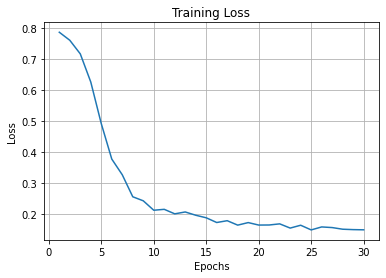

In [ ]:
# Plot the history of a metric during a training episode

data = np.array([history.history["loss"]])
epochs = range(1, data.shape[-1]+1)

fig = plt.figure()
plt.plot(epochs, np.transpose(data))
plt.yscale("linear")
plt.grid(True, which='both')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

fig.savefig( os.path.join(LOSS_DIR, "loss_{}.png".format(MODEL_NAME) ) )


(11, 70) (11, 70)
(100, 7) (100, 7)


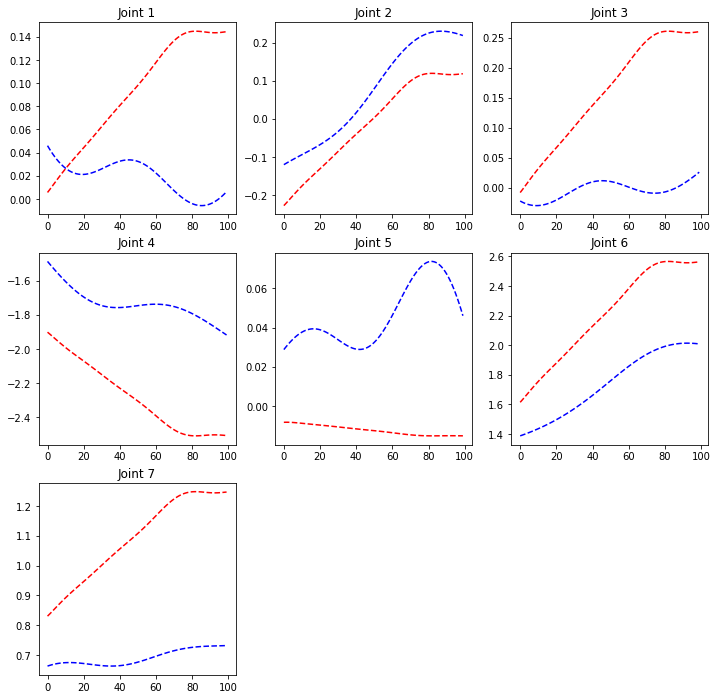

In [ ]:
# Test case 
N = 4

y_pred = model.predict( X_val )

print ( y_pred.shape, y_val.shape ) 

traj_test = promp.trajectory_from_weights( y_val[N] )
traj_pred = promp.trajectory_from_weights( y_pred[N] )
print (traj_test.shape, traj_pred.shape )

fig = plt.figure(2, figsize=(12,12))

for i in range(7):
  plt.subplot(3,3,i+1)
  plt.plot( traj_test[:, i] , 'r--') 
  plt.plot( traj_pred[:, i] , 'b--') 
  plt.title("Joint {}".format(i+1))
